In [2]:
%load_ext autoreload
%autoreload 2

# Injury analysis

## Imports

In [35]:
import importlib
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
from Project_Injuries.utils.read import load_data_consolidated
import Project_Injuries.data_processing as dp
import Project_Injuries.math_models as mm
from Project_Injuries.plots import regression_plot
importlib.reload(mm)

import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Loading

In [4]:
data_frames = load_data_consolidated("data")

data\injury_data_consolidated.xlsx


## Modeling preparation (partition into train set and test set)

In [5]:
train_test_sets = dp.basketball_process_test_train(data_frames["Summary_Basketball"])

## Linear Regression for predicting Scored points, scored assists, and rebounds taken over after injury

We consider first multi feature regression then single variable linear regressionn

In [45]:
results_mul, results_single=mm.linear_regr_basket(train_test_sets)

We present results which are not admirable to small dataset, also we see that in the data set players are of comparable strength as mean is quite good predictor. Only for estimating points was linear regression better that just mean value!

In [8]:
results_mul

,Coefficients,Intercept,R²,Model,Target
0,"[0.6755870141941588, 0.11851450449777698, -0.4...",4.758523,0.344952,3 variables,PTS
1,"[-0.0659645284072114, 0.8847474476153478, -0.1...",1.672795,-0.018969,3 variables,AST
2,"[0.06067034971689756, -0.07359135440942371, 0....",0.538213,-1.661078,3 variables,REB


In [9]:
results_single

,Coefficients,Intercept,R²,Model,Target
0,[0.6179789146860954],3.786918,0.254732,1 variable,PTS
1,[0.8430249678409247],0.227495,-0.080913,1 variable,AST
2,[0.6698216491565823],0.880844,-1.906682,1 variable,REB


Let us provide plot of this regression for points. We spot a lot of outliers, but some point with big Y coefficient adjust to trendd line. It is worth noticing many players did even better after injury.

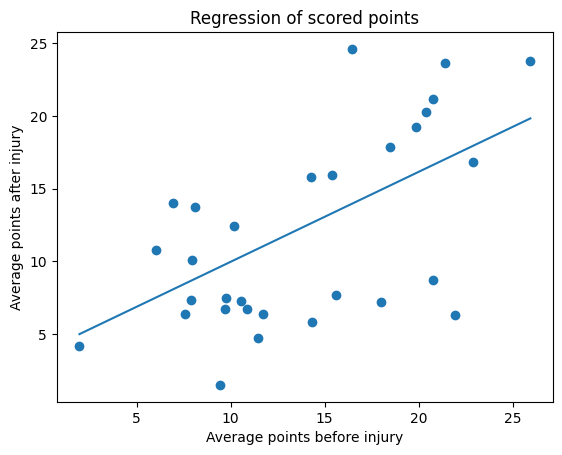

In [11]:
X_pts, Y_pts= dp.processing_for_lr_plot(train_test_sets)
coef = results_single.loc[0, 'Coefficients']  # make sure it's a scalar or array
intercept = results_single.loc[0, 'Intercept']
regression_plot(X_pts, Y_pts, intercept, coef, "Average points before injury", "Average points after injury", "Regression of scored points")

Let us briefly analize collegiate basketball, as only couple injuries are registered, we will have a closer look by dividing data set. Fortunnately as shown below no NAN are present and there is more records then previously.

In [12]:
injured, healthy = dp.collegiate_prepare_knn(data_frames['Collegiate_Processed'])

liczba braków danych:
 Age                            0
Height_cm                      0
Weight_kg                      0
Training_Intensity             0
Training_Hours_Per_Week        0
Recovery_Days_Per_Week         0
Match_Count_Per_Week           0
Rest_Between_Events_Days       0
Fatigue_Score                  0
Performance_Score              0
Team_Contribution_Score        0
Load_Balance_Score             0
ACL_Risk_Score                 0
Injury_Indicator               0
BMI                            0
Training_Load_Score            0
Gender_Female                  0
Gender_Male                    0
Position_Center                0
Position_Forward               0
Position_Guard                 0
ACL_Risk_Category_High         0
ACL_Risk_Category_Low          0
ACL_Risk_Category_Medium       0
ACL_Risk_Category_Very High    0
dtype: int64


We use k-nearest neighbours method for analysis, first we split data

In [13]:
X_train, y_train, X_test, y_test = dp.ml_split_collegiate(injured, healthy)

Now we have statistics, which are wonderfull, maybe partially because of small amount of injuries. We would like to share idea of spliting at 1/2, which is non standard but here allows to grasp understanding of this rare events of injury, while having ability to test recognition of those.

In [42]:
models_res = mm.scaling_fitting_knn(X_train, y_train, X_test, y_test)

Accuracy for 1 neighbours: 0.98
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        93
           1       0.86      0.86      0.86         7

    accuracy                           0.98       100
   macro avg       0.92      0.92      0.92       100
weighted avg       0.98      0.98      0.98       100

Accuracy for 2 neighbours: 0.98
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        93
           1       0.86      0.86      0.86         7

    accuracy                           0.98       100
   macro avg       0.92      0.92      0.92       100
weighted avg       0.98      0.98      0.98       100

Accuracy for 3 neighbours: 0.98
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        93
           1       0.86      0.86      0.86         7

    accuracy                           0.98       100
   macro avg       0.92      0.9

Visualization of models performances as well as two main factors and their impact on injury (see the following chart)

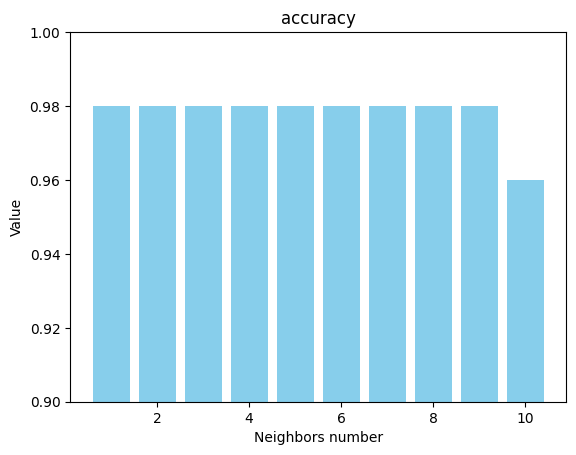

In [44]:
plt.bar([i+1 for i in range(10)], models_res[1], color='skyblue')  # kolor opcjonalny
plt.title('accuracy')
plt.ylim(0.9, 1) 
plt.xlabel('Neighbors number')
plt.ylabel('Value')
plt.show()

In [31]:
result.importances_mean

array([0.   , 0.003, 0.009, 0.001, 0.007, 0.   , 0.   , 0.   , 0.002,
       0.006, 0.01 , 0.01 , 0.01 , 0.002, 0.001, 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   ])

In [33]:
knn =  KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)
result = permutation_importance(knn, X_test, y_test, n_repeats=20, random_state=42)
feature_names = X_test.columns.tolist()
feature_importance = [(feature_names[i], v) for i, v in enumerate(result.importances_mean)]

# sortujemy po wartości importance malejąco
feature_importance_sorted = sorted(feature_importance, key=lambda x: x[1], reverse=True)

# wyświetlamy
for feature, importance in feature_importance_sorted:
    print(f"{feature}: {importance:.4f}")

ACL_Risk_Score: 0.0100
Load_Balance_Score: 0.0100
Team_Contribution_Score: 0.0095
Weight_kg: 0.0090
Training_Hours_Per_Week: 0.0070
Performance_Score: 0.0065
Height_cm: 0.0050
BMI: 0.0035
Training_Intensity: 0.0010
Fatigue_Score: 0.0010
Training_Load_Score: 0.0010
Age: 0.0000
Recovery_Days_Per_Week: 0.0000
Match_Count_Per_Week: 0.0000
Rest_Between_Events_Days: 0.0000
Gender_Female: 0.0000
Gender_Male: 0.0000
Position_Center: 0.0000
Position_Forward: 0.0000
Position_Guard: 0.0000
ACL_Risk_Category_High: 0.0000
ACL_Risk_Category_Low: 0.0000
ACL_Risk_Category_Medium: 0.0000
ACL_Risk_Category_Very High: 0.0000


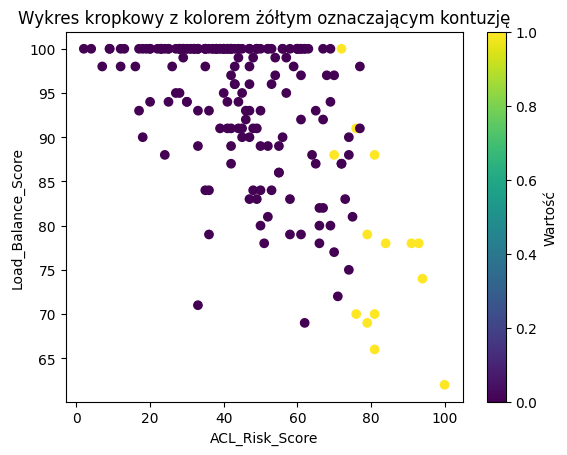

In [41]:
X = pd.concat((X_train, X_test))
y = pd.concat((y_train, y_test))
X = X[["ACL_Risk_Score", "Load_Balance_Score"]]

plt.scatter(X.ACL_Risk_Score, X.Load_Balance_Score, c=y, cmap='viridis')
plt.colorbar(label='Wartość')

plt.xlabel('ACL_Risk_Score')
plt.ylabel('Load_Balance_Score')
plt.title('Wykres kropkowy z kolorem żółtym oznaczającym kontuzję')
plt.show()